This code analyzes the relationship between air and stream temperature signals by quantifying two key metrics:

Amplitude Ratio: This metric represents the relative magnitude of the stream temperature fluctuations compared to the air temperature fluctuations.

Phase Lag: This metric quantifies the temporal displacement between the air and stream temperature signals.


0. import packages

In [1]:
from datetime import datetime
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
!pip install dataretrieval
from dataretrieval import nwis
from sklearn.linear_model import LinearRegression
current_time = datetime.now()
print(current_time.strftime("%Y-%m-%d %H:%M:%S"))

2025-06-19 15:36:59


1. input

In [2]:
startDate = "1995-10-01"
endDate = "2024-09-30"

model_site = ["12305000","12322000","13092747","13150430","13154500","13176400","13190500","13192200","13211205","13213000","13296000","13304050","13307000"
              ,"13310800" # ST all zeros in 2015
              ,"13310850","13311000","13311250","13311450","13317660","13337095","13340000","13340600","13341050","13342500"]

units_day = 365


2. output

In [3]:
from google.colab import drive


drive.mount('/content/drive')

# complete ws charateristics including elevation and watershed size
ws_charateristics ='/content/drive/MyDrive/ws_charateristics_202506141754.csv'  # Update this path

#ws_charateristics = "../ws_charateristics/ws_charateristics.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# df from PRISM and USGS, including rad_d  00010_Mean  00060_Mean
daily_df = '/content/drive/My Drive/'+"df_cleaned_"+   current_time.strftime("%Y%m%d%H%M") + '.csv'
# ws_charateristics and PASTA
ws_pasta = '/content/drive/My Drive/'+"site_amp3_"+   current_time.strftime("%Y%m%d%H%M") + '.csv'

3.  get nwis info

In [5]:
site_info = nwis.get_info(sites= model_site )

site_info_df = pd.DataFrame( site_info[0] )

site_info_df["site_no"]=site_info_df["site_no"].astype(str)

columns_to_save = ['site_no', 'dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va', 'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd' ]

filtered_df = site_info_df[columns_to_save]

filtered_df

,site_no,dec_lat_va,dec_long_va,drain_area_va,contrib_drain_area_va,alt_va,alt_meth_cd,alt_acy_va,alt_datum_cd
0,12305000,48.616883,-116.049194,11740.0,NaN,1794.75,Z,0.64,NAVD88
1,12322000,48.996389,-116.507500,13700.0,NaN,1700.00,M,20.00,NGVD29
2,13092747,42.562500,-114.494722,259.0,NaN,3630.00,M,1.00,NGVD29
3,13150430,43.323361,-114.108350,70.0,NaN,4834.45,Y,0.02,NAVD88
4,13154500,43.002222,-115.202500,35800.0,35800.0,2495.13,X,0.37,NAVD88
5,13176400,42.261369,-116.868442,2140.0,NaN,4253.65,Y,0.08,NAVD88
6,13190500,43.343611,-115.477500,978.0,NaN,3833.07,X,0.26,NAVD88
7,13192200,43.550556,-115.721944,1172.0,NaN,NaN,NaN,NaN,NaN
8,13211205,43.677353,-116.701131,3363.0,3363.0,2337.11,Y,0.05,NAVD88
9,13213000,43.781667,-116.972778,3906.0,NaN,2199.46,Z,0.03,NAVD88


4. get prism df

In [6]:
shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"

file_id = shared_url.split('/d/')[1].split('/')[0]

download_url = f"https://drive.google.com/uc?id={file_id}"

prism_df = pd.read_csv(download_url)

prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)

prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365

prism_df["site_no"] =prism_df["site_no"].astype(str)

# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)

prism_df["site_no"] =prism_df["site_no"].astype(str)

print( prism_df)

prism_df['Date'] = prism_df['date'].dt.date

print( prism_df.dtypes )

print(  prism_df["site_no"].unique()  )


             date      tmean   site_no  Days_Since_October_1st     rad_d
0      1995-01-01 -18.306002  06038800                      92  1.583707
1      1995-01-02 -17.829000  06038800                      93  1.600921
2      1995-01-03 -18.317001  06038800                      94  1.618135
3      1995-01-04 -15.904000  06038800                      95  1.635350
4      1995-01-05 -11.903001  06038800                      96  1.652564
...           ...        ...       ...                     ...       ...
282875 2024-10-10  14.149199  13342500                       9  0.154928
282876 2024-10-11  13.611249  13342500                      10  0.172142
282877 2024-10-12  16.385151  13342500                      11  0.189356
282878 2024-10-13  14.676150  13342500                      12  0.206570
282879 2024-10-14  16.204950  13342500                      13  0.223785

[282880 rows x 5 columns]
date                      datetime64[ns]
tmean                            float64
site_no        

5. get nwis dv

In [7]:
parameterCode = ["00010","00060"  ]

dailyStreamtemp = nwis.get_dv(sites= model_site

                              , parameterCd=parameterCode, start=startDate, end=endDate)

dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

print( dailyStreamtemp_df)

         site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
0       12305000 1995-10-01 00:00:00+00:00            NaN              NaN   
1       12305000 1995-10-02 00:00:00+00:00            NaN              NaN   
2       12305000 1995-10-03 00:00:00+00:00            NaN              NaN   
3       12305000 1995-10-04 00:00:00+00:00            NaN              NaN   
4       12305000 1995-10-05 00:00:00+00:00            NaN              NaN   
...          ...                       ...            ...              ...   
173686  13342500 2024-09-26 00:00:00+00:00           16.1                A   
173687  13342500 2024-09-27 00:00:00+00:00           16.1                A   
173688  13342500 2024-09-28 00:00:00+00:00           16.6                A   
173689  13342500 2024-09-29 00:00:00+00:00           15.7                A   
173690  13342500 2024-09-30 00:00:00+00:00           14.2                A   

        00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_c

plot

         site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
0       12305000 1995-10-01 00:00:00+00:00            NaN              NaN   
1       12305000 1995-10-02 00:00:00+00:00            NaN              NaN   
2       12305000 1995-10-03 00:00:00+00:00            NaN              NaN   
3       12305000 1995-10-04 00:00:00+00:00            NaN              NaN   
4       12305000 1995-10-05 00:00:00+00:00            NaN              NaN   
...          ...                       ...            ...              ...   
173686  13342500 2024-09-26 00:00:00+00:00           16.1                A   
173687  13342500 2024-09-27 00:00:00+00:00           16.1                A   
173688  13342500 2024-09-28 00:00:00+00:00           16.6                A   
173689  13342500 2024-09-29 00:00:00+00:00           15.7                A   
173690  13342500 2024-09-30 00:00:00+00:00           14.2                A   

        00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_c

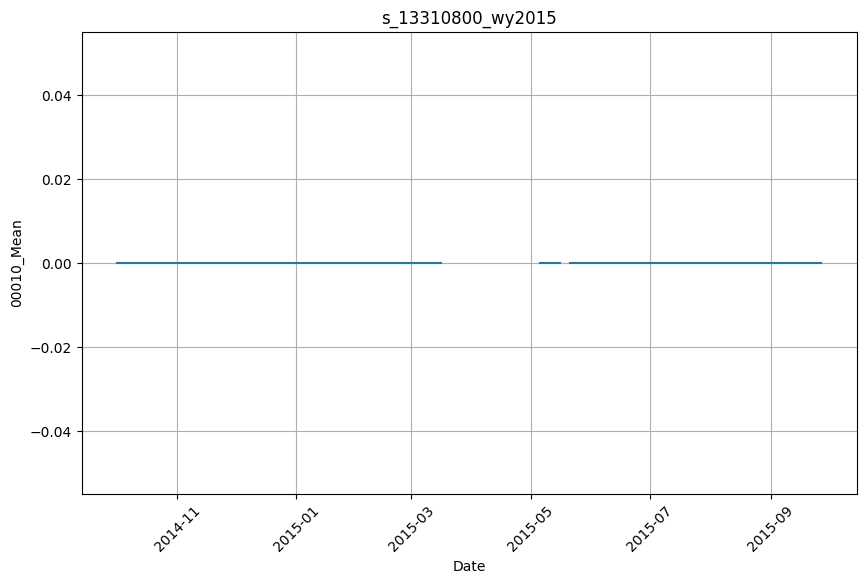

In [8]:


s_13310800_wy2015 =dailyStreamtemp_df[ (dailyStreamtemp_df["site_no"]=="13310800") &
(dailyStreamtemp_df["Date"] >=  datetime.strptime("2014-10-01", "%Y-%m-%d").date() ) &
    (dailyStreamtemp_df["Date"] <  datetime.strptime("2015-10-01", "%Y-%m-%d").date() )

]


dailyStreamtemp_df = dailyStreamtemp_df[ ~(  (dailyStreamtemp_df["site_no"]=="13310800") &
(dailyStreamtemp_df["Date"] >=  datetime.strptime("2014-10-01", "%Y-%m-%d").date() ) &
    (dailyStreamtemp_df["Date"] <  datetime.strptime("2015-10-01", "%Y-%m-%d").date() )

 ) ]

print(dailyStreamtemp_df)

# Plot the data
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(  s_13310800_wy2015['Date'],  s_13310800_wy2015['00010_Mean'])
plt.xlabel('Date')
plt.ylabel('00010_Mean')
plt.title('s_13310800_wy2015')
plt.grid(True)

plt.xticks(rotation=45)

# Show the plot
plt.show()

In [9]:
#print(prism_df['date'])
#print(dailyStreamtemp_df['Date'])

6. merge prism_df and dailyStreamtemp_df

In [10]:
prism_df = prism_df[['tmean' , "site_no", 'Date', "rad_d" ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',
  '00010_Mean', '00060_Mean',
       'Month', 'Year' ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

print(result)


            tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
0        9.922001  13092747  1995-10-01  0.000000         NaN       176.0   
1       10.795000  13092747  1995-10-02  0.017214         NaN       178.0   
2       10.739000  13092747  1995-10-03  0.034428         NaN       186.0   
3        5.081000  13092747  1995-10-04  0.051643         NaN       196.0   
4        7.834001  13092747  1995-10-05  0.068857         NaN       187.0   
...           ...       ...         ...       ...         ...         ...   
173321  16.438400  13342500  2024-09-26  6.197114        15.0      3300.0   
173322  18.511250  13342500  2024-09-27  6.214328        15.0      3190.0   
173323  22.026501  13342500  2024-09-28  6.231543        15.5      3190.0   
173324  12.077950  13342500  2024-09-29  6.248757        14.8      3120.0   
173325  11.494699  13342500  2024-09-30  6.265971        13.1      3100.0   

        Month  Year  
0          10  1995  
1          10  1995  
2        

7. remove NA

In [11]:
# Count the number of NaN values in each column
na_count = result.isna().sum()

# Print the result
print(na_count)

# Drop rows with any NaN values
df_cleaned = result.dropna()

# Print the cleaned DataFrame
print(df_cleaned)

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

# Print the result
print(na_count)


tmean             0
site_no           0
Date              0
rad_d             0
00010_Mean    61912
00060_Mean     8705
Month             0
Year              0
dtype: int64
            tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
286     23.403002  13092747  1996-07-13  4.906049        18.6       120.0   
287     23.366001  13092747  1996-07-14  4.923263        18.4       130.0   
288     24.110001  13092747  1996-07-15  4.940477        18.3       132.0   
289     21.022001  13092747  1996-07-16  4.957691        17.9       134.0   
290     21.528002  13092747  1996-07-17  4.974906        18.0       155.0   
...           ...       ...         ...       ...         ...         ...   
173321  16.438400  13342500  2024-09-26  6.197114        15.0      3300.0   
173322  18.511250  13342500  2024-09-27  6.214328        15.0      3190.0   
173323  22.026501  13342500  2024-09-28  6.231543        15.5      3190.0   
173324  12.077950  13342500  2024-09-29  6.248757        

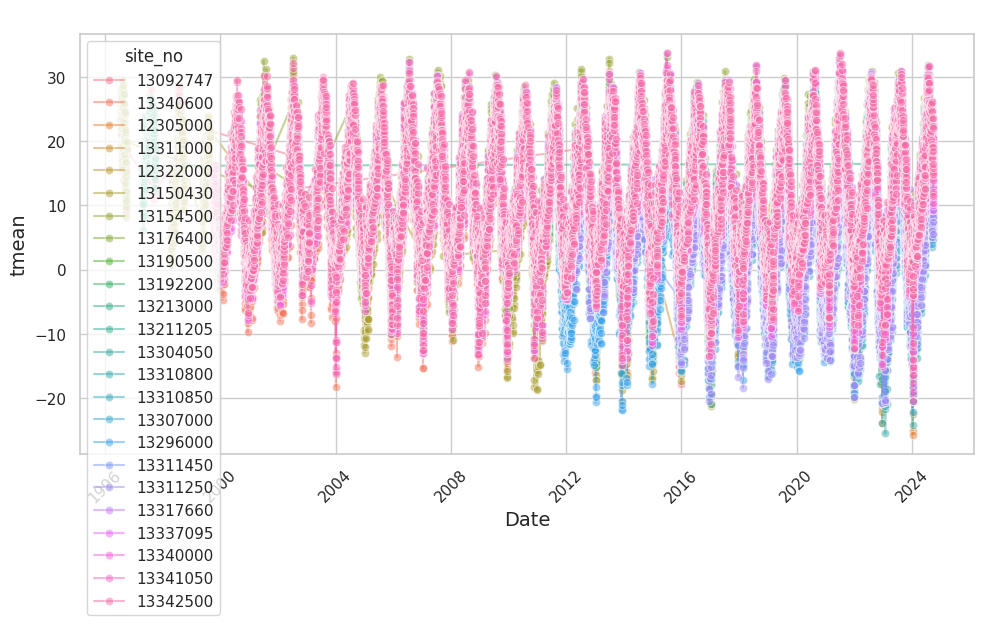

In [12]:
df=df_cleaned
y="tmean"
c="site_no"
x="Date"

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Use seaborn's lineplot, color by 'site_no'
sns.lineplot(data=df, x=x, y=y, hue=c, marker='o',alpha = 0.5)

# Customize plot labels and title
plt.title(' ', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('tmean', fontsize=14)

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

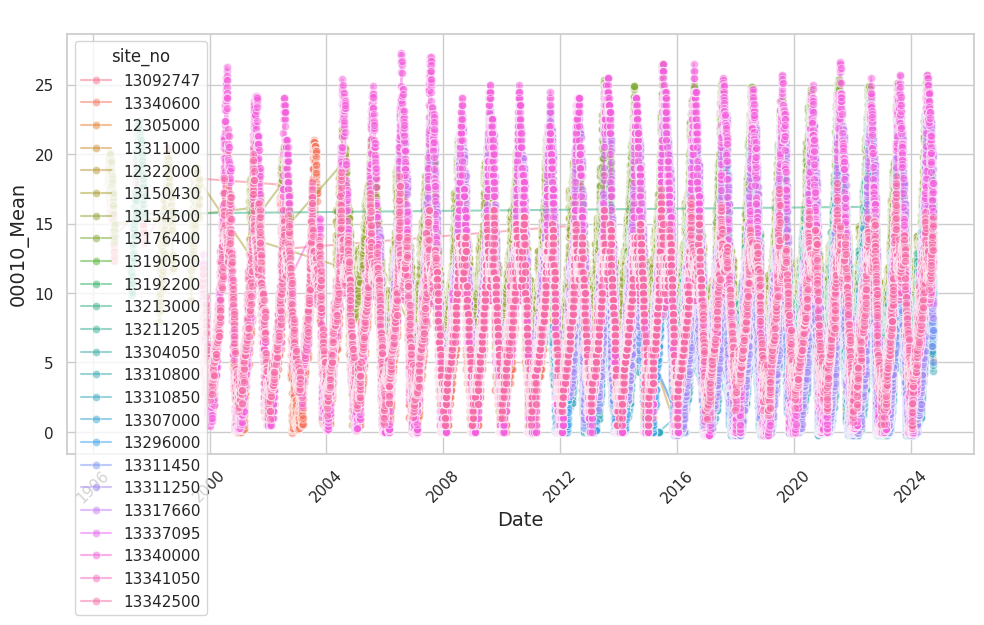

In [13]:
df=df_cleaned
y="00010_Mean"
c="site_no"
x="Date"

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Use seaborn's lineplot, color by 'site_no'
sns.lineplot(data=df, x=x, y=y, hue=c, marker='o',alpha = 0.5)

# Customize plot labels and title
plt.title(' ', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(y , fontsize=14)

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

8. get water year

In [14]:
def get_water_year(date):
        if date.month >= 10:
            #print(date)
            return date.year +1
            #print(date.year+1)
        else:
            return date.year




In [15]:
amp_df = pd.DataFrame({
                        "site": [ "00000000"],


                        "amp": [ 0.0 ],
     "ph_l": [  0.0  ]
                                })
df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)

print(df_cleaned)

df_cleaned.to_csv( daily_df )

/tmp/ipython-input-15-1278472268.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)


            tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
286     23.403002  13092747  1996-07-13  4.906049        18.6       120.0   
287     23.366001  13092747  1996-07-14  4.923263        18.4       130.0   
288     24.110001  13092747  1996-07-15  4.940477        18.3       132.0   
289     21.022001  13092747  1996-07-16  4.957691        17.9       134.0   
290     21.528002  13092747  1996-07-17  4.974906        18.0       155.0   
...           ...       ...         ...       ...         ...         ...   
173321  16.438400  13342500  2024-09-26  6.197114        15.0      3300.0   
173322  18.511250  13342500  2024-09-27  6.214328        15.0      3190.0   
173323  22.026501  13342500  2024-09-28  6.231543        15.5      3190.0   
173324  12.077950  13342500  2024-09-29  6.248757        14.8      3120.0   
173325  11.494699  13342500  2024-09-30  6.265971        13.1      3100.0   

        Month  Year  water_year  
286         7  1996        1996  
287    

9. pasta every site

In [16]:
for site in model_site:
    merged_df_wy=df_cleaned[df_cleaned['site_no']==site ]

    merged_df_wy['sin_rday'] = np.sin( merged_df_wy['rad_d'] )
    merged_df_wy['cos_rday'] = np.cos( merged_df_wy['rad_d'] )

    num_rows = merged_df_wy.shape[0]
    print("Number of rows:", num_rows)
    if num_rows <90:
        print("stop")
    else:
        air_model =    smf.ols('tmean ~ sin_rday + cos_rday',      data=  merged_df_wy ).fit()
        air_model_coefficients = air_model.params
        air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5

        merged_df_wy['fit_air'] = air_model.predict( merged_df_wy )
        merged_df_wy['ST']=merged_df_wy['00010_Mean']
        stream_model = smf.ols('ST ~ sin_rday + cos_rday', data= merged_df_wy ).fit()
        stream_model_coefficients = stream_model.params


        stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5

        merged_df_wy['fit_stream'] = stream_model.predict( merged_df_wy )

## phase

        ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )

        ph_air =    ( units_day/(2*math.pi) ) * ( (3 * math.pi / 2) - math.atan(  air_model_coefficients[2] / air_model_coefficients[1] )      )

        ph_l = ph_stream - ph_air


##



        amp_df0 = pd.DataFrame({
                                "site": [site]


                                    ,"amp": [stream_amp / air_amp]
           , "ph_l": [ ph_l ]
                                })

        amp_df=pd.concat( [amp_df,amp_df0] )




/tmp/ipython-input-16-1707478349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_wy['sin_rday'] = np.sin( merged_df_wy['rad_d'] )
/tmp/ipython-input-16-1707478349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_wy['cos_rday'] = np.cos( merged_df_wy['rad_d'] )
/tmp/ipython-input-16-1707478349.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

Number of rows: 4413
Number of rows: 3539
Number of rows: 4683
Number of rows: 6436
Number of rows: 7640
Number of rows: 4253


/tmp/ipython-input-16-1707478349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_wy['sin_rday'] = np.sin( merged_df_wy['rad_d'] )
/tmp/ipython-input-16-1707478349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_wy['cos_rday'] = np.cos( merged_df_wy['rad_d'] )
/tmp/ipython-input-16-1707478349.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

Number of rows: 1814
Number of rows: 3029
Number of rows: 3077
Number of rows: 466
Number of rows: 4272
Number of rows: 843


/tmp/ipython-input-16-1707478349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_wy['sin_rday'] = np.sin( merged_df_wy['rad_d'] )
/tmp/ipython-input-16-1707478349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_wy['cos_rday'] = np.cos( merged_df_wy['rad_d'] )
/tmp/ipython-input-16-1707478349.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

Number of rows: 2989
Number of rows: 2736
Number of rows: 2857
Number of rows: 2904
Number of rows: 3651
Number of rows: 2704


/tmp/ipython-input-16-1707478349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_wy['sin_rday'] = np.sin( merged_df_wy['rad_d'] )
/tmp/ipython-input-16-1707478349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_wy['cos_rday'] = np.cos( merged_df_wy['rad_d'] )
/tmp/ipython-input-16-1707478349.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

Number of rows: 6899
Number of rows: 96
Number of rows: 8552
Number of rows: 8898
Number of rows: 7885
Number of rows: 9011


/tmp/ipython-input-16-1707478349.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-16-1707478349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_wy['fit_air'] = air_model.predict( merged_df_wy )
/tmp/ipython-input-16-1707478349.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [17]:
print(amp_df)
amp_df = amp_df[1:]
print(amp_df)

       site       amp       ph_l
0  00000000  0.000000   0.000000
0  12305000  0.501713  28.067854
0  12322000  0.595400  22.359741
0  13092747  0.471255   6.327435
0  13150430  0.632628  -7.784095
0  13154500  0.439203   2.744142
0  13176400  0.945167  -4.255680
0  13190500  0.258282  52.710403
0  13192200  0.399247  20.470535
0  13211205  0.613282  12.576885
0  13213000  0.656940   8.897418
0  13296000  0.567011   4.645172
0  13304050  0.569762   2.420003
0  13307000  0.759584   2.251612
0  13310800  0.422738   5.343710
0  13310850  0.442767   6.097145
0  13311000  0.482903   5.019632
0  13311250  0.520727   6.568820
0  13311450  0.444537   3.621792
0  13317660  0.824244  17.400700
0  13337095  0.800905   3.580548
0  13340000  0.913567  10.524372
0  13340600  0.762943  10.089354
0  13341050  0.418316  10.479532
0  13342500  0.460745   9.294641
       site       amp       ph_l
0  12305000  0.501713  28.067854
0  12322000  0.595400  22.359741
0  13092747  0.471255   6.327435
0  1315043

10. watershed charateristics

In [18]:
missing_ele = pd.read_csv( ws_charateristics
#    "drain_area_va_df_clean.csv"
)

missing_ele['site'] = missing_ele['site_no'].astype(str)

#missing_ele['site'] = missing_ele['site'].astype(str)
#missing_ele['site_no'] = missing_ele['site'].astype(str)

#print( missing_ele.columns )
print( missing_ele  )

     site_no  dec_lat_va  dec_long_va  drain_area_va      alt_va  \
0   12305000   48.616883  -116.049194        11740.0  1794.75000   
1   12322000   48.996389  -116.507500        13700.0  1700.00000   
2   13092747   42.562500  -114.494722          259.0  3630.00000   
3   13150430   43.323361  -114.108350           70.0  4834.45000   
4   13154500   43.002222  -115.202500        35800.0  2495.13000   
5   13176400   42.261369  -116.868442         2140.0  4253.65000   
6   13190500   43.343611  -115.477500          978.0  3833.07000   
7   13192200   43.550556  -115.721944         1172.0  3323.49092   
8   13211205   43.677353  -116.701131         3363.0  2337.11000   
9   13213000   43.781667  -116.972778         3906.0  2199.46000   
10  13296000   44.278889  -114.733889          189.0  5950.00000   
11  13304050   44.688792  -113.370406           81.3  5938.25000   
12  13307000   45.322500  -114.440000         6239.0  3157.59000   
13  13310800   44.902250  -115.325667           

11. merge amp_df (pasta) and missing_ele (ws characteristics)

In [19]:
#amp_df
#filtered_df
site_amp=pd.merge( amp_df
                  ,missing_ele #,  filtered_df
                  , left_on='site'
                  ,right_on= 'site' #'site_no'
                  , how='inner')
site_amp

,site,amp,ph_l,site_no,dec_lat_va,dec_long_va,drain_area_va,alt_va,comment,dike_regulation,dam,diversion,dam_and_diversion
0,12305000,0.501713,28.067854,12305000,48.616883,-116.049194,11740.0,1794.75000,NaN,NaN,Dam,No diversion,Dam
1,12322000,0.595400,22.359741,12322000,48.996389,-116.507500,13700.0,1700.00000,NaN,Boundary dike of Reclamation Farm and U.S. For...,Dam,No diversion,Dam
2,13092747,0.471255,6.327435,13092747,42.562500,-114.494722,259.0,3630.00000,NaN,NaN,No dam,Diversion,Diversion
3,13150430,0.632628,-7.784095,13150430,43.323361,-114.108350,70.0,4834.45000,NaN,NaN,No dam,Diversion,Diversion
4,13154500,0.439203,2.744142,13154500,43.002222,-115.202500,35800.0,2495.13000,"springs and seepage entering below Milner, irr...",NaN,Dam,Diversion,Dam and diversion
5,13176400,0.945167,-4.255680,13176400,42.261369,-116.868442,2140.0,4253.65000,no USGS remark,NaN,No dam,No diversion,No flow regulation
6,13190500,0.258282,52.710403,13190500,43.343611,-115.477500,978.0,3833.07000,NaN,NaN,Dam,Diversion,Dam and diversion
7,13192200,0.399247,20.470535,13192200,43.550556,-115.721944,1172.0,3323.49092,NaN,NaN,Dam,No diversion,Dam
8,13211205,0.613282,12.576885,13211205,43.677353,-116.701131,3363.0,2337.11000,NaN,NaN,No dam,Diversion,Diversion
9,13213000,0.656940,8.897418,13213000,43.781667,-116.972778,3906.0,2199.46000,NaN,NaN,No dam,Diversion,Diversion


In [20]:
site_amp2 = site_amp[ ['site', 'amp', 'ph_l' ,'drain_area_va' , 'alt_va'
 ] ]
print( site_amp2 )

site_amp2['drain_area_va_2'] = site_amp2['drain_area_va']

site_amp2['site'] = site_amp2['site'].astype(str)

site_amp3=site_amp

#site_amp3 = pd.merge(missing_ele, site_amp2, on='site', how='outer')

#site_amp3.loc[site_amp3["drain_area_va_2"].isna(), "drain_area_va_2"] = site_amp3.loc[site_amp3["drain_area_va_2"].isna(), "drain_area_va_x"]

site_amp3.to_csv( ws_pasta  )

print("site_amp3:",site_amp3)


        site       amp       ph_l  drain_area_va      alt_va
0   12305000  0.501713  28.067854        11740.0  1794.75000
1   12322000  0.595400  22.359741        13700.0  1700.00000
2   13092747  0.471255   6.327435          259.0  3630.00000
3   13150430  0.632628  -7.784095           70.0  4834.45000
4   13154500  0.439203   2.744142        35800.0  2495.13000
5   13176400  0.945167  -4.255680         2140.0  4253.65000
6   13190500  0.258282  52.710403          978.0  3833.07000
7   13192200  0.399247  20.470535         1172.0  3323.49092
8   13211205  0.613282  12.576885         3363.0  2337.11000
9   13213000  0.656940   8.897418         3906.0  2199.46000
10  13296000  0.567011   4.645172          189.0  5950.00000
11  13304050  0.569762   2.420003           81.3  5938.25000
12  13307000  0.759584   2.251612         6239.0  3157.59000
13  13310800  0.422738   5.343710            9.1  6546.00000
14  13310850  0.442767   6.097145            5.7  6639.00000
15  13311000  0.482903  

/tmp/ipython-input-20-3551336705.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_amp2['drain_area_va_2'] = site_amp2['drain_area_va']
/tmp/ipython-input-20-3551336705.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_amp2['site'] = site_amp2['site'].astype(str)


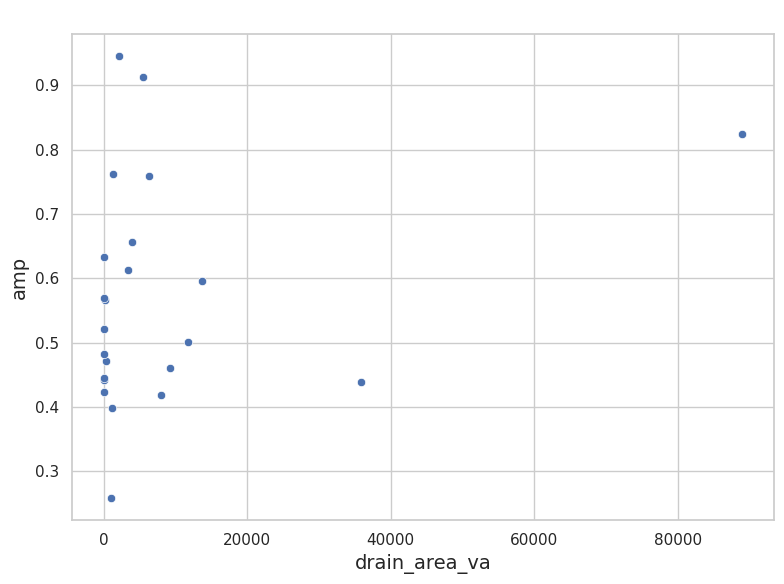

In [21]:
#import seaborn as sns

x = "drain_area_va"
y = "amp"

df= site_amp3[ [ x , y]].dropna()


# Create a seaborn scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x= x, y= y
               # , color='purple'
               )

# Customize the plot
plt.title(' ', fontsize=16)
plt.xlabel( x, fontsize=14)
plt.ylabel( y, fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

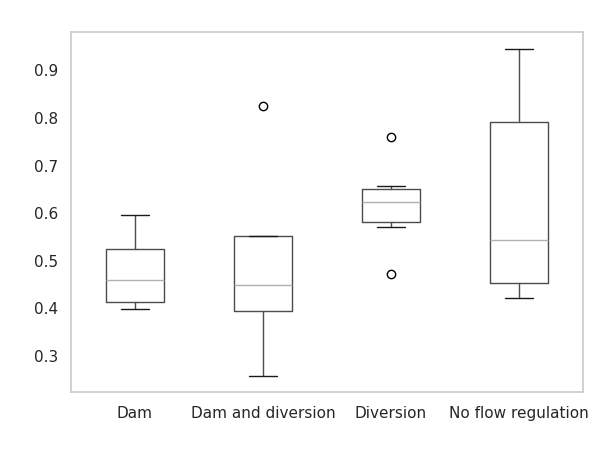

In [22]:



site_amp3.boxplot(column='amp', by='dam_and_diversion', grid=False)

# Adding labels and title
plt.title(' ')
plt.suptitle('')  # Removes the default matplotlib super title
plt.xlabel(' ')
plt.ylabel(' ')

# Show the plot
plt.show()

/tmp/ipython-input-23-396644565.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dam_and_diversion', y='amp', data=site_amp3, palette='pastel')


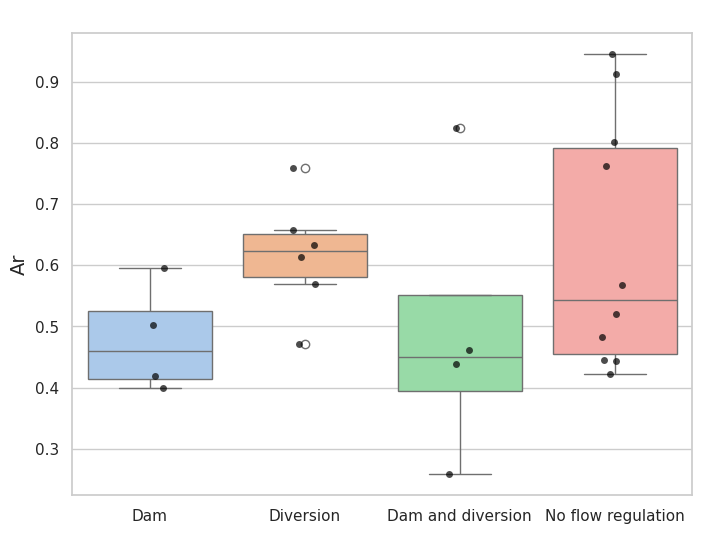

In [23]:
# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='dam_and_diversion', y='amp', data=site_amp3, palette='pastel')

# Overlay the original data points
sns.stripplot(x='dam_and_diversion', y='amp', data= site_amp3,
              color='black', alpha=0.7, jitter=True, dodge=True)

# Add labels and title
plt.title(' ', fontsize=14)
plt.xlabel('  ', fontsize= 14)
plt.ylabel('Ar', fontsize= 14)

# Save the figure
plt.savefig("Ar_reg.png")

# Show the plot
plt.show()

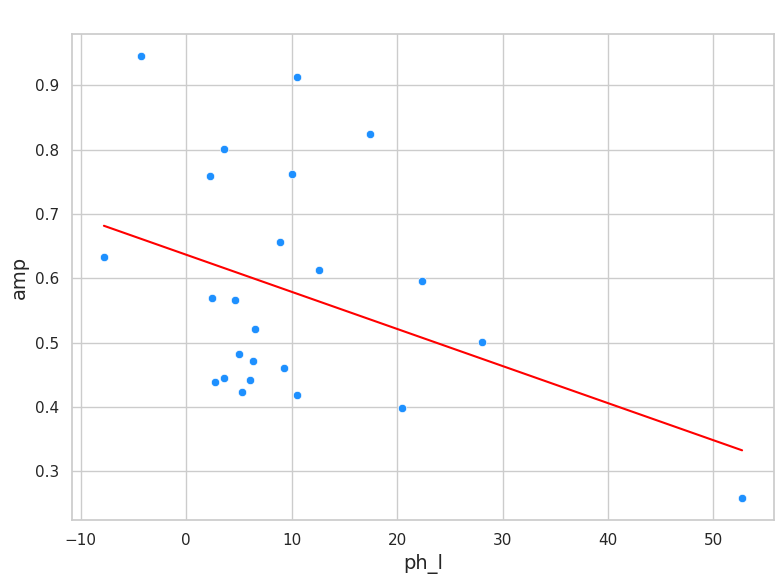

In [24]:
x = "ph_l"
y = "amp"



df=site_amp3[ [ x , y]].dropna()

import seaborn as sns

# Create a seaborn scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x= x, y= y , color='dodgerblue'
               )

# Fit linear regression model
model = LinearRegression()
model.fit(df[[x]], df[y])
# Predict values
predictions = model.predict(df[[x]])
# Plot the regression line
sns.lineplot(x=df[x], y=predictions, color='red')

# Customize the plot
plt.title(' ', fontsize=16)
plt.ylabel(  y, fontsize=14)
plt.xlabel(  x , fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()


In [25]:
# Phase is converted from radians to day-of-year using 3π/2 − arctan(b/a)

print( stream_model_coefficients )
#a: coef of sin_rday

print( "a: ",stream_model_coefficients[1] )

print( "b: ",stream_model_coefficients[2] )

ph_stream= (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] )

print("ph_stream:", ph_stream)

print( air_model_coefficients )
#a: coef of sin_rday

print( "a: ", air_model_coefficients[1] )

print( "b: ", air_model_coefficients[2] )

ph_air = (3 * math.pi / 2) - math.atan(  air_model_coefficients[2] / air_model_coefficients[1] )

print("ph_air:", ph_air)

ph_l = ph_stream - ph_air

ph_l

Intercept    8.372436
sin_rday    -4.539259
cos_rday     2.276355
dtype: float64
a:  -4.539258665630006
b:  2.2763545168187966
ph_stream: 5.1772211348296535
Intercept    11.611722
sin_rday    -10.513287
cos_rday      3.307889
dtype: float64
a:  -10.513286877399837
b:  3.3078889214705685
ph_air: 5.01722125844529


/tmp/ipython-input-25-526304029.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print( "a: ",stream_model_coefficients[1] )
/tmp/ipython-input-25-526304029.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print( "b: ",stream_model_coefficients[2] )
/tmp/ipython-input-25-526304029.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream= (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficie

0.1599998763843633

In [26]:



# Arctangent of a number (in radians)
x = 1
result_radians = math.atan(x)

# Convert the result to degrees
result_degrees = math.degrees(result_radians)

print(f'Arctangent of {x} in radians: {result_radians}')
print(f'Arctangent of {x} in degrees: {result_degrees}')


Arctangent of 1 in radians: 0.7853981633974483
Arctangent of 1 in degrees: 45.0
